In [1]:
#Imports
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np

import random

from ast import literal_eval
from src.model_funcs import run_em, tolerance_sort, max_posterior_label
from src.plotting_funcs import  plot_ternary_axes, plot_ternary_bounds, CB_color_cycle

# Bayesian Mixture Model

**Goal**: Model the uncertainty expressed by multiple annotations
**Tool**: Multinomial Mixture Model
- There exists a latent ground truth, i.e. a "true label" for each sentence
- This latent ground truth is unambiguous but the annotator’s opinion about it is not
- We set up a distributional framework and model the observed annotations under the assumption that there exists a latent true label
- The parameters of the associated distributions allow us to analyse the sources of labelling uncertainty and we can estimate the latent labels through the posterior probabilities

Assume latent ground truth:

$Z^{(i)}\sim Multi(\boldsymbol{\pi}, 1)$ iid.  $\rightarrow$ prior

Given latent true class, the labellers' votes follow:

$Y^{(i)}|Z^{(i)}\sim Multi(\boldsymbol{\theta_{Z^{(i)}}}, 100)$ iid. $\rightarrow$ likelihood

or explicitly:
$Y^{(i)}|(Z^{(i)} = entail) \sim Multi(\boldsymbol{\theta_{entail}}, 100) \\
Y^{(i)}|(Z^{(i)} = neutral) \sim Multi(\boldsymbol{\theta_{neutral}}, 100)\\
Y^{(i)}|(Z^{(i)} = contradict) \sim Multi(\boldsymbol{\theta_{contradict}}, 100).$


Use Bayes Rule to model latent ground truth given votes:

$\tau^{(i)}_l = P(Z^{(i)}=l|Y^{(i)}) = \frac{P(Z^{(i)}=l) \cdot P(Y^{(i)}|Z^{(i)} = l)}{P(Y^{(i)})} = \frac{prior \cdot likelihood}{evidence}$



Apply Expectation Maximization (EM) algorithm, iteratively estimate latent ground truth and parameters

1. E-Step:
calculate posterior class probabilities $\tau^{(i)}_l$ given $\pi$ and $\theta_{Z^{(i)}}$, i.e., parameters of prior and likelihood
choose class with highest posterior as latent ground truth class $Z^{(i)}$

2. M-Step:
update $\pi$ and $\theta_{Z^{(i)}}$ given $\tau^{(i)}_l$, i.e.,  posterior class probabilities

Initial values:
- $\pi$ = (1/3, 1/3, 1/3)
- $\theta$ drawn from dirichlet with $\alpha$ = (6,6,6) (i.e., 2* number_of_observed_classes)

In [2]:
df_snli = pd.read_csv('../data/final/snli-clean.csv', index_col=0)
df_snli.old_labels = df_snli.old_labels.apply(literal_eval) # since quotes in list elements are escaped

In [3]:
#extract relevant columns
snli_one_hot = df_snli[['e', 'n', 'c']]
snli_one_hot_arr = np.array(snli_one_hot).astype(int)

#frequency of all votes
rel_freq = np.sum(snli_one_hot_arr,axis=0)/(100*len(snli_one_hot_arr))

#frequency of personal ground truth
gt_freq = np.unique(df_snli['ground_truth'],return_counts=True)
#as the labels are initially sorted alphabetically, we manually fix the order: E, N, C
rel_freq_gt = gt_freq[1][[1,2,0]]/len(df_snli)

#frequency of majority vote label
m_vote_freq = np.unique(df_snli['majority_label'], return_counts=True)
#as the labels are initially sorted alphabetically, we manually fix the order: E, N, C
rel_freq_m_vote = m_vote_freq[1][[1,2,0]]/len(df_snli)

In [4]:
random.seed(12)
snli_em = run_em(snli_one_hot_arr, K=3)

In [5]:
theta_matched,matched_index = tolerance_sort(snli_em[2], 0.05, reverse=True)

pi_matched = snli_em[1][matched_index]
tau_matched = snli_em[3][:, matched_index]

In [6]:
theta_matched

array([[0.72754973, 0.23774587, 0.0347044 ],
       [0.13715878, 0.79277892, 0.0700623 ],
       [0.03049156, 0.30765757, 0.66185087]])

In [7]:
lc = df_snli.label_count.to_numpy()
lc = [literal_eval(x) for x in lc]

/Users/corneliagruber/anaconda3/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


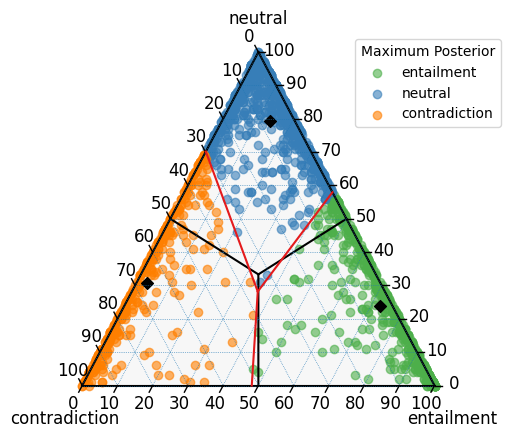

In [11]:
df_snli['z_hat'] = max_posterior_label(tau_matched)

labels = ['e', 'n', 'c']
colors = [ CB_color_cycle[2], CB_color_cycle[0], CB_color_cycle[1]]
labels_text = ['entailment', 'neutral', 'contradiction']

figure, tax = plot_ternary_axes(size = 5)
tax = plot_ternary_bounds(tax, pi = pi_matched, theta=theta_matched)

for label, color, text in zip(labels, colors, labels_text):
    lc = df_snli.loc[df_snli['z_hat'] == label, 'label_count'].values.tolist()
    lc = [literal_eval(x) for x in lc]
    tax.scatter(lc, alpha = 0.6, color = color, label = text)
tax.scatter(theta_matched*100, color = 'black', marker='D')    
tax.legend(title = 'Maximum Posterior', bbox_to_anchor=(0.75, 1), loc='upper left', borderaxespad=0)

figure.savefig("../figs/scatter_latent.png", bbox_inches='tight', dpi=300)